In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from sklearn.utils import resample
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

C:\Users\vigne\AppData\Local\Temp\ipykernel_3692\3055513589.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


READING DATASET

In [2]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",delimiter=',', encoding = "ISO-8859-1")
df.columns = ["sentiment", "id", "date", "query", "user", "text"]

In [3]:
df.head()

,sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


EDA- EXPLORATORY DATA ANALYSIS AND DATA PREPROCESSING

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1599999 non-null  int64 
 1   id         1599999 non-null  int64 
 2   date       1599999 non-null  object
 3   query      1599999 non-null  object
 4   user       1599999 non-null  object
 5   text       1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.describe()

,sentiment,id
count,1.599999e+06,1.599999e+06
mean,2.000001e+00,1.998818e+09
std,2.000001e+00,1.935757e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956916e+09
50%,4.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [6]:
df.isnull().sum()

sentiment    0
id           0
date         0
query        0
user         0
text         0
dtype: int64

In [7]:
df=df[['text','sentiment']]

In [8]:
df['sentiment'][df['sentiment']==4]=1

C:\Users\vigne\AppData\Local\Temp\ipykernel_3692\3113900530.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['sentiment'][df['sentiment']==4]=1


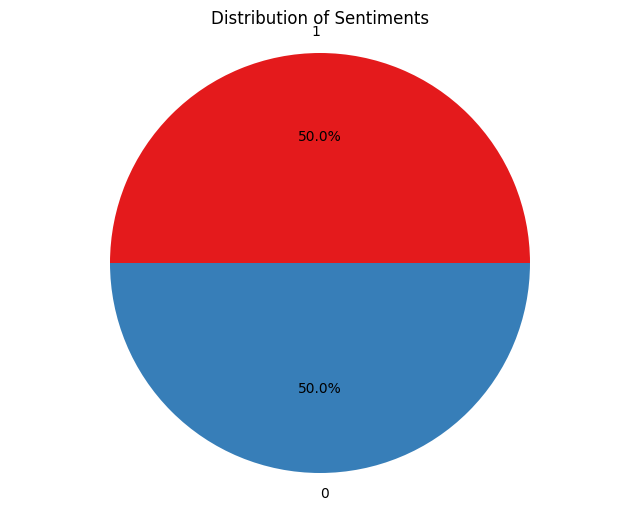

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set1'))
plt.title('Distribution of Sentiments')
plt.axis('equal')  
plt.show()


In [10]:
df['text'].isnull().sum()

0

In [11]:
df=df.drop_duplicates('text')

TEXT PROCESSING(STEMMING)

In [12]:
stuff_to_be_removed = list(punctuation)
def textprocessing(text):
    text = str(text)
    text = text.lower()                                                          
    text = re.sub(r"https\S+|www\S+|https\S+"," ",text,flags=re.MULTILINE)       
    text=re.sub("(\\d|\\W)+"," ",text)       
    text = re.sub(r'\@\w+|\#'," ",text)                                         
    text = re.sub(r'[^\w\s\`]'," ",text)                                        
    text_tokens = word_tokenize(text) 
    lem = SnowballStemmer("english")
    text = [lem.stem(word) for word in text_tokens if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    
    return text1 

In [13]:
data_cleaned = pd.DataFrame()
df['text'] = df['text'].apply(textprocessing)
df['text'].head()

0    is upset that he can t updat his facebook by t...
1    kenichan i dive mani time for the ball manag t...
2         my whole bodi feel itchi and like it on fire
3    nationwideclass no it s not behav at all i m m...
4                          kwesidei not the whole crew
Name: text, dtype: object

In [44]:
negative_text = ' '.join(df[df['sentiment'] == 0]['text'])
positive_text = ' '.join(df[df['sentiment'] == 1]['text'])
df = df[['sentiment','text']]
df.head()

,sentiment,text
0,0,is upset that he can t updat his facebook by t...
1,0,kenichan i dive mani time for the ball manag t...
2,0,my whole bodi feel itchi and like it on fire
3,0,nationwideclass no it s not behav at all i m m...
4,0,kwesidei not the whole crew


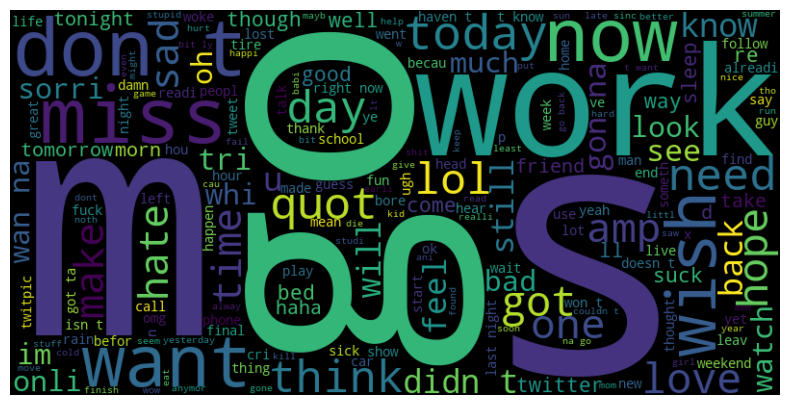

In [45]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

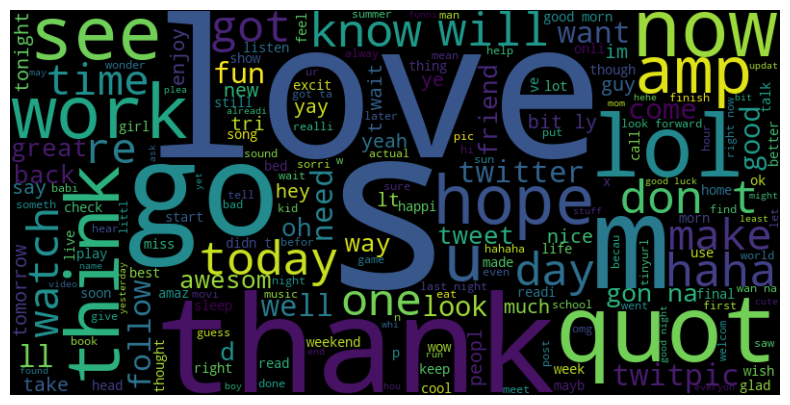

In [16]:
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(positive_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

VECTORIZATION

In [17]:
x = df['text']
y = df['sentiment']

vectorizer = tf()
vectors = vectorizer.fit_transform(x)
vectors

<1581465x559292 sparse matrix of type '<class 'numpy.float64'>'
	with 18723151 stored elements in Compressed Sparse Row format>

TRAIN-TEST SPLIT

In [18]:
X_train_svm, X_temp_svm, y_train_svm, y_temp_svm = train_test_split(vectors, y, test_size=0.3, random_state=52)

X_validation_svm, X_test_svm, y_validation_svm, y_test_svm = train_test_split(X_temp_svm, y_temp_svm, test_size=0.5, random_state=52)

SVM MODEL

In [19]:
classifier = CalibratedClassifierCV(LinearSVC(dual = True), method='sigmoid')
classifier.fit(X_train_svm, y_train_svm)

CalibratedClassifierCV(estimator=LinearSVC(dual=True))

In [47]:
svm_predictions_train = classifier.predict(X_train_svm)

accuracy = accuracy_score(y_train_svm, svm_predictions_train)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_train_svm, svm_predictions_train))

Accuracy: 0.87
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87    553451
           1       0.87      0.88      0.87    553574

    accuracy                           0.87   1107025
   macro avg       0.87      0.87      0.87   1107025
weighted avg       0.87      0.87      0.87   1107025



In [21]:
svm_prediction_test = classifier.predict(X_test_svm)


accuracy = accuracy_score(y_test_svm, svm_prediction_test)
print(f"Accuracy: {accuracy:.2f}")


print("Classification Report:")
print(classification_report(y_test_svm, svm_prediction_test))

Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79    118443
           1       0.79      0.80      0.79    118777

    accuracy                           0.79    237220
   macro avg       0.79      0.79      0.79    237220
weighted avg       0.79      0.79      0.79    237220



In [22]:
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Negative', 'Positive']) 
    disp_train.plot(ax=axes[0], cmap='YlGnBu', values_format='d', colorbar=True)
    axes[0].set_title('Training Confusion Matrix')
    axes[0].tick_params(axis='both', which='major', labelsize=10) 
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Negative', 'Positive'])  
    disp_test.plot(ax=axes[1], cmap='viridis', values_format='d', colorbar=True)
    axes[1].set_title('Testing Confusion Matrix')
    axes[1].tick_params(labelsize=10)
    plt.tight_layout()  
    plt.show()

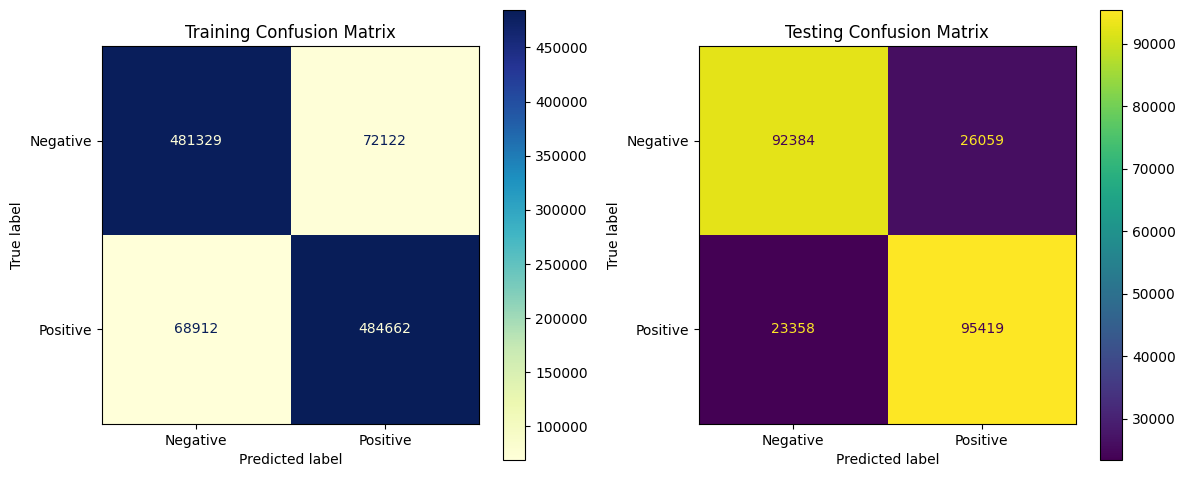

In [23]:
metrics(y_train_svm,svm_predictions_train ,y_test_svm,svm_prediction_test)

In [24]:
new_text = "The pie was not tasty"
new_text_vector = vectorizer.transform([new_text])

prediction = classifier.predict(new_text_vector)

if prediction[0] == 1:
    print("positve user comment")
else:
    print("negative user comment")

negative user comment


LOGISTIC REGRESSION MODEL

In [25]:
model=LogisticRegression(max_iter=1000,C=1,penalty='l2',solver='liblinear')

In [26]:
model.fit(X_train_svm,y_train_svm)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')

In [27]:
x_train_prediction=model.predict(X_train_svm)
training_data_accuracy=accuracy_score(y_train_svm,x_train_prediction)

In [28]:
print(f"Accuracy score={training_data_accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_train_svm, x_train_prediction))

Accuracy score=0.82
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.81      0.82    553451
           1       0.81      0.84      0.82    553574

    accuracy                           0.82   1107025
   macro avg       0.82      0.82      0.82   1107025
weighted avg       0.82      0.82      0.82   1107025



In [29]:
x_test_prediction=model.predict(X_test_svm)
testing_data_accuracy=accuracy_score(y_test_svm,x_test_prediction)

In [30]:
print(f'Accuracy score={testing_data_accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test_svm, x_test_prediction))

Accuracy score=0.80
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.79    118443
           1       0.79      0.81      0.80    118777

    accuracy                           0.80    237220
   macro avg       0.80      0.80      0.80    237220
weighted avg       0.80      0.80      0.80    237220



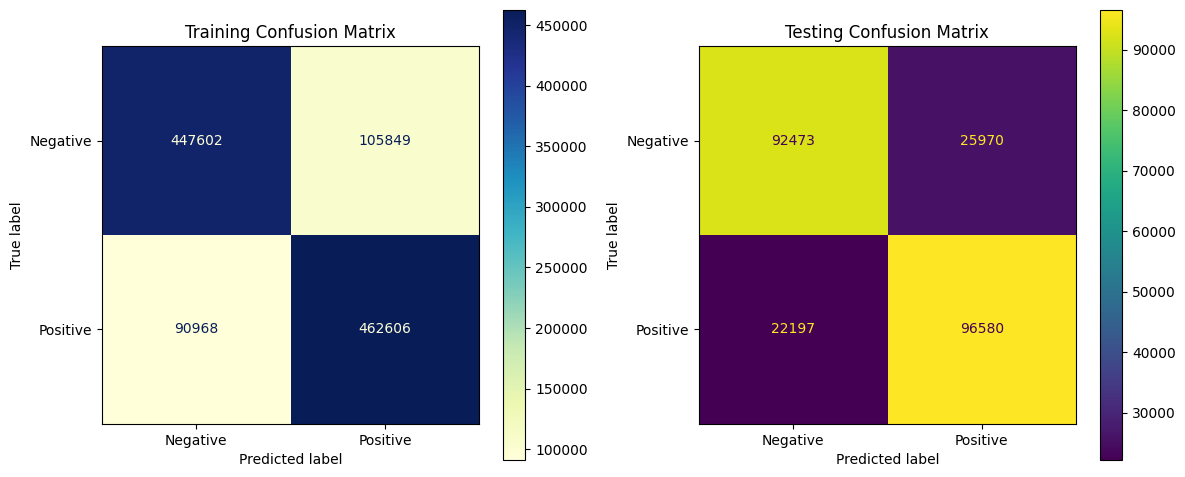

In [31]:
metrics(y_train_svm,x_train_prediction ,y_test_svm,x_test_prediction)

NAIVE BAYES MODEL

In [32]:

nb_classifier = MultinomialNB(alpha=1.0, fit_prior= True)
nb_classifier.fit(X_train_svm, y_train_svm)


MultinomialNB()

In [33]:
train_predictions = nb_classifier.predict(X_train_svm)
train_accuracy = accuracy_score(y_train_svm, train_predictions)


In [34]:

print(f'Accuracy score={train_accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_train_svm,train_predictions))


Accuracy score=0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84    553451
           1       0.86      0.79      0.82    553574

    accuracy                           0.83   1107025
   macro avg       0.83      0.83      0.83   1107025
weighted avg       0.83      0.83      0.83   1107025



In [35]:
test_predictions = nb_classifier.predict(X_test_svm)
test_accuracy = accuracy_score(y_test_svm, test_predictions)


In [36]:
print(f'Accuracy score={test_accuracy:.2f}')
print("Classification Report:")
print(classification_report(y_test_svm, test_predictions))

Accuracy score=0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.81      0.78    118443
           1       0.79      0.72      0.75    118777

    accuracy                           0.77    237220
   macro avg       0.77      0.77      0.77    237220
weighted avg       0.77      0.77      0.77    237220



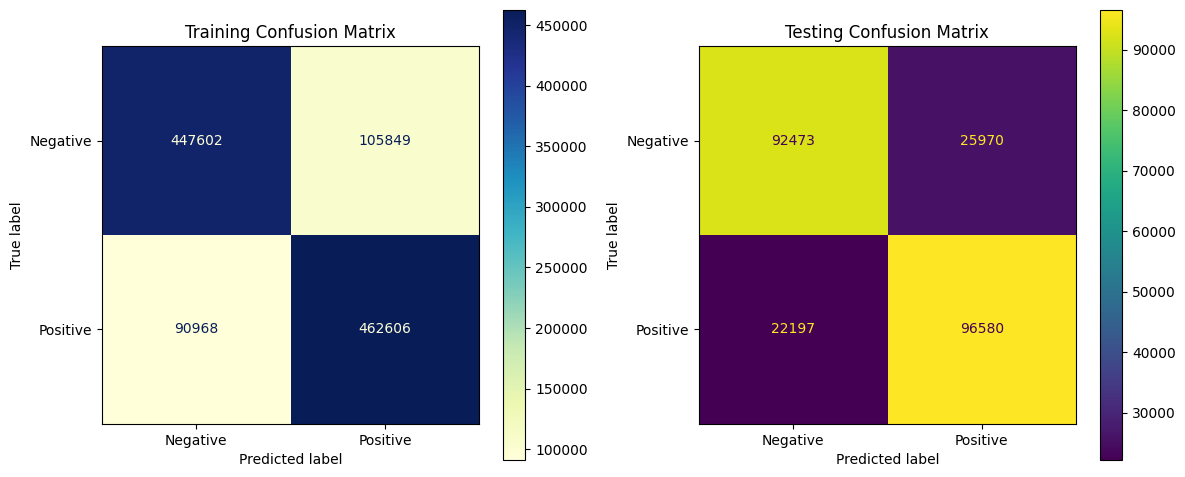

In [37]:
metrics(y_train_svm,x_train_prediction ,y_test_svm,x_test_prediction)

SAVING A TRAINED MODEL USING PICKLE

In [38]:
import pickle
filename='1.6miltwitter.sav'
pickle.dump(model,open(filename,'wb'))

In [39]:
load_model=pickle.load(open('1.6miltwitter.sav','rb'))

RUNNING TESTS ON CUSTOM DATA

In [40]:
new_text = "The pie was not tasty"
new_text_vector = vectorizer.transform([new_text])

prediction = load_model.predict(new_text_vector)

if prediction[0] == 1:
    print("positve user comment")
else:
    print("negative user comment")

negative user comment


In [41]:
new_text = "What a wonderful day!"
new_text_vector = vectorizer.transform([new_text])

prediction = load_model.predict(new_text_vector)

if prediction[0] == 1:
    print("positve user comment")
else:
    print("negative user comment")

positve user comment
